In [1]:
# Base
import librosa # alternativa pyAudioAnalysis ali audioFlux
import numpy as np
import os
import h5py
import time
import datetime
from scipy import signal
import matplotlib.pyplot as plt

# Preprocessing, Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Keras, Classification
import keras
from keras import models
from keras import layers
from sklearn.svm import SVC
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

# Parameters
genres = np.array('pop rock classical blues country disco metal jazz reggae hiphop'.split())
n_genres = len(genres)
n_genres_files = 100  # število datotek v posamezni mapi žanra
n_features = 6
n_mfcc_coef = 20
n_parts_sig = 6   # signali so dolgi 30 sekund, vsak del mora trajati 5 sekund

In [2]:
def extract_features(y, sr, n_features, n_mfcc_coef, n_fft=512, hop_length=160, window=signal.windows.hamming(512), fmin=300, fmax=8000):
    vect = np.zeros(n_features + n_mfcc_coef)

    #https://devopedia.org/audio-feature-extraction#qst-ans-4

    #zero_crossing_rate šteje, kako pogosto signal prečka x-os
    #tempo ocenjuje število udarcev na minuto
    #tempogram meri, kako se tempo spreminja skozi čas
    #rms izračuna energijo signala
    #spectral_centroid izračuna frekvenčni pas, v katerem je skoncentrirana večina energije
    #spectral_bandwidth podaja varianco od spektralnega_centroida

    #y and sr are sampled data and sampling rate, respectively
    #n_fft is the number of the fft coefficients
    #hop_length is the distance between two frames
    #window is the used window function (Hamming)
    #fmin and fmax are minimum and maximum frequencies
    
    vect[0] = np.mean(librosa.feature.zero_crossing_rate(y))
    vect[1] = np.mean(librosa.feature.tempo(y=y, sr=sr))
    vect[2] = np.mean(librosa.feature.tempogram(y=y, sr=sr))
    vect[3] = np.mean(librosa.feature.rms(y=y))
    vect[4] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    vect[5] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

    # MFCC
    # Can use Kapre (https://github.com/keunwoochoi/kapre) GPU
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc_coef)

    for i in range(0, n_mfcc_coef):
        vect[i + n_features] = np.mean(mfcc[i])

    return vect

In [8]:
# Dataset - Will take some time to generate
data = np.zeros((n_genres * n_genres_files * n_parts_sig, n_features + n_mfcc_coef))
data_labels = np.zeros((n_genres * n_genres_files * n_parts_sig, 1))

data_index = 0
for i_genre in range(0, n_genres):
    for filename in os.listdir(f'C:\\Users\\Viktorija\\Desktop\\ROSIS\\N8\\Data\\genres_original\\{genres[i_genre]}'):
        fn = f'C:\\Users\\Viktorija\\Desktop\\ROSIS\\N8\\Data\\genres_original\\{genres[i_genre]}\\{filename}'

        # There is one problematic file - format problem (can try ffmpeg decoder)
        try:
            # Load file (sig-signal; sr-sampling rate)
            sig, sr = librosa.load(fn, mono=True, duration=30)

            # Split signals into smaller chunks
            for y in np.split(sig, n_parts_sig):
                
                # Features - Data
                data[data_index, 0:n_features + n_mfcc_coef] = extract_features(sig, sr, n_features, n_mfcc_coef)

                # Genre - Label
                data_labels[data_index] = i_genre

                data_index = data_index + 1
        except:
            pass

# Save to h5 file
hf = h5py.File('dataset.h5', 'w')
hf.create_dataset('data', data=data)
hf.create_dataset('data_labels', data=data_labels)
hf.close()

C:\Users\Viktorija\AppData\Local\Temp\ipykernel_13656\1276745270.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  sig, sr = librosa.load(fn, mono=True, duration=30)


In [3]:
# Load dataset from h5 file
hf = h5py.File('dataset.h5', 'r')

data = hf.get('data')
data = np.array(data)

data_labels = hf.get('data_labels')
data_labels = np.array(data_labels)

print('Data size:', np.shape(data))
print('Data_labels size:', np.shape(data_labels))

hf.close()

Data size: (6000, 26)
Data_labels size: (6000, 1)


Train: (3600, 1)
Test: (1200, 1)
Val: (1200, 1)


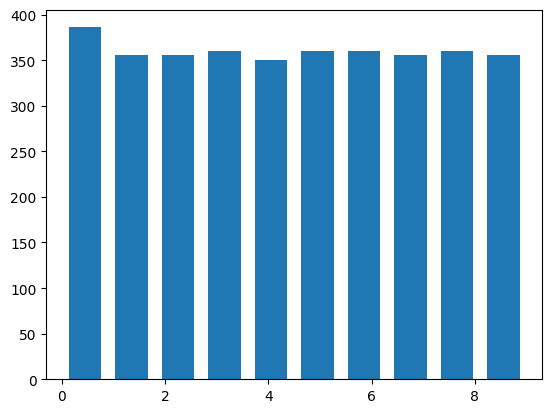

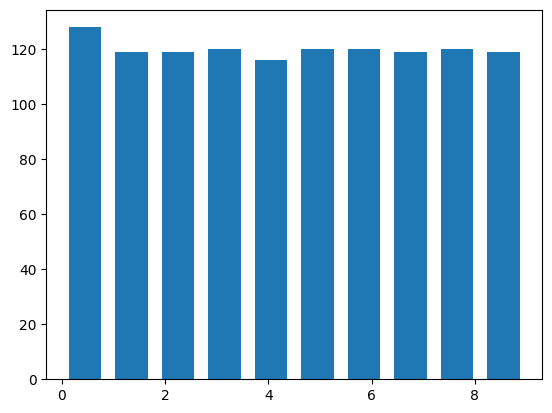

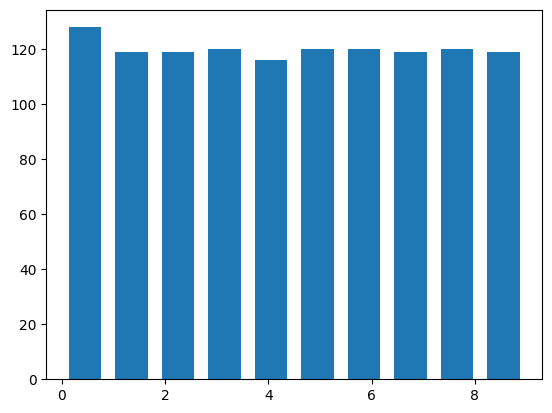

In [4]:
# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data, dtype = float))

# Split into test and train
# Why stratify=data_labels?
# Check the histograms, try removing stratify
X_train, X_test, y_train, y_test = train_test_split(X, data_labels, test_size=0.2, stratify=data_labels)

# Split into train and valid
# Why stratify=y_train?
# Check the histograms, try removing stratify
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

# Sizes
print('Train:', np.shape(y_train))
print('Test:', np.shape(y_test))
print('Val:', np.shape(y_val))

# The truth is — there is no optimal split percentage
# train 80%; valid 10%; test 10%
# train 70%; valid 15%; test 15%
# tarin 60%; valid 20%; test 20%

plt.hist(y_train, bins=n_genres, rwidth=0.7)
plt.show()
plt.hist(y_test, bins=n_genres, rwidth=0.7)
plt.show()
plt.hist(y_val, bins=n_genres, rwidth=0.7)
plt.show()

In [5]:
# NN
#https://medium.com/@sdoshi579/classification-of-music-into-different-genres-using-keras-82ab5339efe0
model = models.Sequential()
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(n_genres, activation='softmax')) # Output layer - 10 genres

opt = keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy() # Computes the crossentropy loss between the labels and predictions
metr = keras.metrics.SparseCategoricalAccuracy() # Calculates how often predictions match integer labels
model.compile(optimizer=opt, loss=loss, metrics=[metr])

In [6]:
# Stopping criterion to avoid overfitting
# patience: Number of epochs with no improvement after which training will be stopped.
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Save best weights
model_checkpoint = ModelCheckpoint("audio_weights.weights.h5", save_best_only=True, save_weights_only=True)

# Train
t_epochs = 100 # Needs to be tuned
b_size = 8 # Needs to be tuned as well - What is batch_size?
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=t_epochs, batch_size=b_size,
                    callbacks=[early_stopping, model_checkpoint])

# Load best weights
model.load_weights("audio_weights.weights.h5")

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3139 - sparse_categorical_accuracy: 0.1435 - val_loss: 1.9932 - val_sparse_categorical_accuracy: 0.3167
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9208 - sparse_categorical_accuracy: 0.3392 - val_loss: 1.7378 - val_sparse_categorical_accuracy: 0.4192
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6816 - sparse_categorical_accuracy: 0.4235 - val_loss: 1.5724 - val_sparse_categorical_accuracy: 0.4692
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5322 - sparse_categorical_accuracy: 0.4690 - val_loss: 1.4500 - val_sparse_categorical_accuracy: 0.5150
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4439 - sparse_categorical_accuracy: 0.5086 - val_loss: 1.3534 - val_sparse_categorical_accuracy: 0.5592
Epoch 6/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3388 - sparse_categorical_accuracy: 0.5534 - val_loss: 1.2740 - val_sparse_categorical_accuracy: 0.578

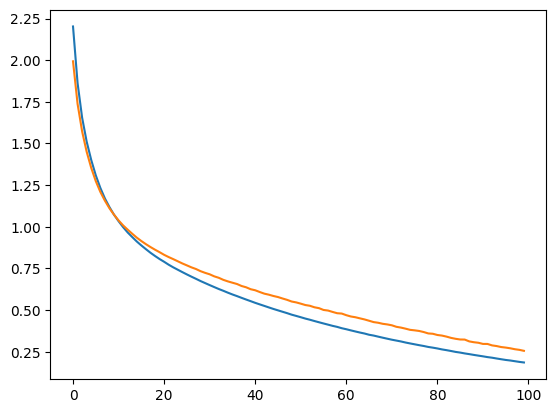

In [7]:
# Lets observe the loss metric on both the training (blue) and validation (orange) set
# What do we noice?

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

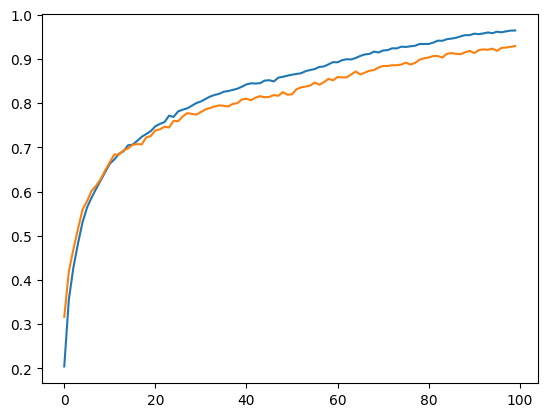

In [8]:
#what do these graphs mean

plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])

In [9]:
# Now to evaluate our model on train and test data

# Train NN
test_loss, test_acc = model.evaluate(X_train, y_train, verbose=0)
print('Acc train NN: %.3f' % test_acc)

# Test NN
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Acc test NN: %.3f' % test_acc)

Acc train NN: 0.966
Acc test NN: 0.942


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


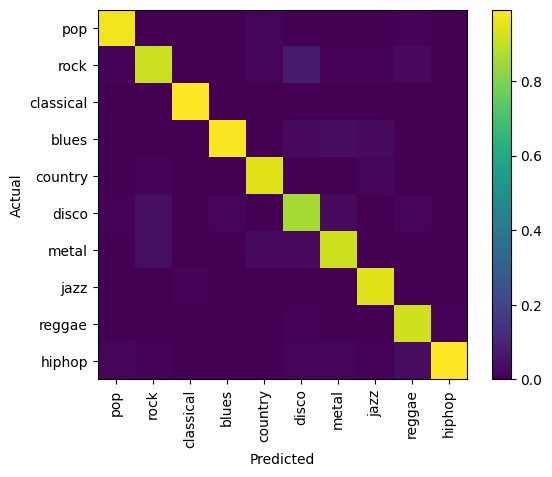

In [10]:
# Test NN
# Predictions for additional analysis
predictions = model.predict(X_test)

# Confusion matrix
predicted_labels = np.argmax(predictions, axis=1)
conf = confusion_matrix(y_test, predicted_labels, normalize="pred")

# Visualise confusion matrix
plt.imshow(conf)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.yticks(np.arange(n_genres), genres)
plt.xticks(np.arange(n_genres), genres, rotation='vertical')
plt.colorbar()

In [ ]:
import datetime
import miniaudio
from IPython.display import clear_output, display

current_title = ""

def title(client: miniaudio.IceCastClient, title: str):
    global current_title
    current_title = title
    
def stream_processing(source):

    predictions = []
    pred_interval = 44100 * 60 # sampling frequency * 60 seconds
    
    sample_count = 0
    
    while True:
        # Get frame - Only one channel - The chunk of signal is too small!
        sample_data = np.array(source.send(8192))[0::2]
        sample_count += len(sample_data)
        
        if len(sample_data) > 0:
            #Features
            feat = extract_features(sample_data, 44100, n_features, n_mfcc_coef)
            
            # Normalization
            feat_norm = scaler.transform(feat.reshape(1, -1))
            pred_nn = model.predict(feat_norm, verbose=0)
            predictions.append(np.argmax(pred_nn[0]))

            clear_output(wait=True)
            print("Title: " + current_title)
            print(datetime.datetime.now())

            most_common = np.bincount(predictions).argmax()
            print("NN: " + genres[most_common])
            
        if sample_count >= pred_interval:

            plt.clf()
            plt.hist(predictions, bins=np.arange(len(genres) + 1) - 0.5)
            plt.xticks(np.arange(len(genres)), genres)
            plt.title('Napovedi žanrov')
            plt.xlabel('Žanr')
            plt.ylabel('Število pojavitev')
            # plt.show()
            print("Save fig!")
            plt.savefig(str("C:\\Users\\Viktorija\\Desktop\\ROSIS\\N8\\mlp_output\\histogram_" + datetime.datetime.now().strftime("%H_%M_%S") + ".png"))

            predictions = []
            sample_count = 0
            
        yield sample_data

# Internet radio source - Radio 1
source = miniaudio.IceCastClient("http://live1.radio1.si/Radio1", update_stream_title=title)

print("Connected")
print("Station: ", source.station_name)

# Stream
stream_in = miniaudio.stream_any(source, source.audio_format, output_format=miniaudio.SampleFormat.FLOAT32)
# Device
device = miniaudio.PlaybackDevice(output_format=miniaudio.SampleFormat.FLOAT32, nchannels=1, sample_rate=44100)

stream = stream_processing(stream_in)
next(stream)
device.start(stream)

while True:
    time.sleep(0.1)

#RICK ASTLEY - TOGETHER FOREVER -> disco
#CALVIN HARRIS & ALESSO FEAT. HURTS - UNDER CONTROL -> disco

Title: CALVIN HARRIS & ALESSO FEAT. HURTS - UNDER CONTROL
2024-08-16 10:55:22.945470
NN: disco
